# Generalised Tight-Binding Equation Solver for BiTeI
George Bird 25/10/22

In [1]:
# Load Dependencies
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt

#### Loading the datasets into an array for further use:

In [2]:
# This method loads the matrix of hoppings
def load_hoppings(filepath):
    """
    Given the filepath, it loads all the relevant complex hoppings into a matrix of shape [Rx, Ry, Rz, Pi, Pj] and normalises
    using the weights.
    :param filepath: String of filepath e.g. BiTeI_hr_trivial.dat
    """
    # Load relevant information from the file
    with open(filepath, "r") as f:
        filetext = f.read()
        weights = filetext.split("\n")[3:80]
        dataset = filetext.split("\n")[80:-1]
        
    # The dataset reads [Rx, Ry, Rz Pi, Pj, T_real, T_imag], here all possible Rx, Ry and Rz values are determined and
    # are stored in sets
    Rx_values = {int(datapoint.split("   ")[1]) for datapoint in dataset}
    Ry_values = {int(datapoint.split("   ")[2]) for datapoint in dataset}
    Rz_values = {int(datapoint.split("   ")[3]) for datapoint in dataset}
    # The minimum and maximum values from these sets are then determined, they are stacked into a list for simplicity
    R_list = [Rx_values, Ry_values, Rz_values]
    # Minimum values
    Rx_min, Ry_min, Rz_min = [min(R) for R in R_list]
    Rx_max, Ry_max, Rz_max = [max(R) for R in R_list]
    
    # Then the weights are seperated out, they are already seperated by row, so they are now further seperated by column
    # and appended into a list. Despite being integers, they are stored as float so that wrong types do not later occur
    weight_list = []
    for weight_row in weights:
        weight_list += [float(weight) for weight in weight_row.split("   ")[1:]]
    
    # Finally the hoppings are stored in a matrix. This matrix is stored below
    hoppings = np.zeros((Rx_max-Rx_min+1, Ry_max-Ry_min+1, Rz_max-Rz_min+1, 18, 18), dtype=np.complex128)
    # There are 1155 weights, which correspond in order to the unique combinations of Rx, Ry, Rz.
    # Thus the unique combinations of Rx, Ry, Rz are stored as an ordered list below
    unique_offsets = [] 
    # Unpack dataset and load hoppings into the matrix
    for datapoint in dataset:
        # Determine the indexings
        Rx, Ry, Rz, Pi, Pj = [int(i) for i in datapoint.split("   ")[1:6]]

        # No repeat entries are wanted in the unique offsets, so in effect an ordered set is generated
        if [Rx, Ry, Rz] not in unique_offsets:
            unique_offsets.append([Rx, Ry, Rz])
        # Then the specific weight is looked up for the current combination of Rx, Ry, Rz
        weights_factor = weight_list[unique_offsets.index([Rx, Ry, Rz])]

        # Represent the hopping as a complex number
        T = float(datapoint.split("   ")[-2]) + 1j*float(datapoint.split("   ")[-1])
        # Fill the corresponding element of the array
        hoppings[Rx-Rx_min, Ry-Ry_min, Rz-Rz_min, Pi-1, Pj-1] = T/weights_factor
    
    # Finally return the hoppings and the respective combinations of Rx, Ry and Rz such that the fourier-like transform
    # can be performed later
    return hoppings, R_list

In [3]:
MAKE_FILES = False
if MAKE_FILES:
    # Load Datasets
    trivial_hoppings, trivial_R = load_hoppings("BiTeI_hr_trivial.dat")
    topological_hoppings, topological_R = load_hoppings("BiTeI_hr_topological.dat")
    # Export Datasets
    pickle.dump([trivial_hoppings, trivial_R], open("BiTeI_hr_trivial.pickle", "wb"))
    pickle.dump([topological_hoppings, topological_R], open("BiTeI_hr_topological.pickle", "wb"))
else:
    # Import Datasets
    trivial_hoppings, trivial_R = pickle.load(open("BiTeI_hr_trivial.pickle", "rb"))
    topological_hoppings, topological_R = pickle.load(open("BiTeI_hr_topological.pickle", "rb"))

#### Determining the energy bands from the supplied hoppings using the tight-binding equation:

In [4]:
def determine_band_structures(hoppings, R_values, k_vectors):
    """
    This method finds the band structure for the specified hoppings, at specific reciprocal lattice space positions.
    :param hoppings: The matrix produced by "load_hoppings" method.
    :param R_values: These are also produced as output of the "load hoppings" method.
    :param k_vectors: This is a torch Tensor of k_vector positions in shape [positions, 3].
    """
    # Load the K-space vectors, then convert to a torch Tensor such that gradient descent can be performed.
    number_of_kpositions = k_vectors.shape[0]
    #k_vectors = torch.tensor(k_vectors, requires_grad=True).type(torch.float64)
    
    # A placeholder matrix is created to store the tight-binding hamiltonians
    TB_hamiltonian = torch.zeros((number_of_kpositions, hoppings.shape[3], hoppings.shape[4]), dtype=torch.complex128)

    # Produce the tight-matrix by summing over the Rx, Ry, Rz values with the respective phases
    for x in range(hoppings.shape[0]):
        for y in range(hoppings.shape[1]):
            for z in range(hoppings.shape[2]):
                R_values = [sorted(list(R)) for R in R_values]
                # Arrange them as an ordered list
                R_vector = torch.tensor([R_values[0][x], R_values[1][y], R_values[2][z]]).reshape(1, 3) # Vector [Rx, Ry, Rz]
                # Find the associated phase factor
                phase_factor = torch.exp(1j*torch.multiply(R_vector, k_vectors).sum(axis=1)).reshape(-1, 1, 1)
                # Obtain the relevant slice of the hopping terms
                hopping_slice = torch.tensor(hoppings[x, y, z, ::].reshape(1, hoppings.shape[3], hoppings.shape[4]))
                # Perform the weighted sum of hoppings with their phase factors
                TB_hamiltonian += torch.multiply(hopping_slice, phase_factor)
    # Hamiltonian has shape [K-points, 18, 18]
    # For every position in K-space determine the eigenvalues:
    # Energy bands is a list containing [K_vector, [ordered eigenvalues], [ordered eigenvectors]]
    eigvals, eigvecs = torch.linalg.eig(TB_hamiltonian)
    return eigvals

#### Graph energy bands:

In [5]:
# How to mix the hamiltonians: (0 trivial to 1 topological)
interpolation_parameter = 0
# Produce linearly interpolated hopping values
interpolated_hoppings = (1-interpolation_parameter)*trivial_hoppings+interpolation_parameter*topological_hoppings

In [6]:
# K-space basis vectors
X = torch.tensor([np.pi, 0, 0], dtype=torch.float64)
Y = torch.tensor([0, np.pi, 0], dtype=torch.float64)
Z = torch.tensor([0, 0, np.pi], dtype=torch.float64)

In [7]:
# Produce a series of random positions in K-space
samples = 75
random_k_positions = torch.rand(samples, 3, dtype=torch.float64, requires_grad=True)
# Scale these values to fill the 1st Brillouin Zone
scaling = torch.tensor([i.numpy() for i in [X, Y, Z]])
random_k_positions = torch.matmul(scaling, random_k_positions.T).T

<ipython-input-7-d14dd2362e71>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  scaling = torch.tensor([i.numpy() for i in [X, Y, Z]])


0 tensor(1.1951, dtype=torch.float64, grad_fn=<MeanBackward0>)
1 tensor(1.1684, dtype=torch.float64, grad_fn=<MeanBackward0>)
2 tensor(1.1227, dtype=torch.float64, grad_fn=<MeanBackward0>)
3 tensor(1.1072, dtype=torch.float64, grad_fn=<MeanBackward0>)
4 tensor(1.1015, dtype=torch.float64, grad_fn=<MeanBackward0>)
5 tensor(1.0939, dtype=torch.float64, grad_fn=<MeanBackward0>)
6 tensor(1.0845, dtype=torch.float64, grad_fn=<MeanBackward0>)
7 tensor(1.0392, dtype=torch.float64, grad_fn=<MeanBackward0>)
8 tensor(1.0026, dtype=torch.float64, grad_fn=<MeanBackward0>)
9 tensor(0.9949, dtype=torch.float64, grad_fn=<MeanBackward0>)
10 tensor(0.9516, dtype=torch.float64, grad_fn=<MeanBackward0>)
11 tensor(0.9332, dtype=torch.float64, grad_fn=<MeanBackward0>)
12 tensor(0.9433, dtype=torch.float64, grad_fn=<MeanBackward0>)
13 tensor(0.9159, dtype=torch.float64, grad_fn=<MeanBackward0>)
14 tensor(0.9113, dtype=torch.float64, grad_fn=<MeanBackward0>)
15 tensor(0.9247, dtype=torch.float64, grad_fn=<Me

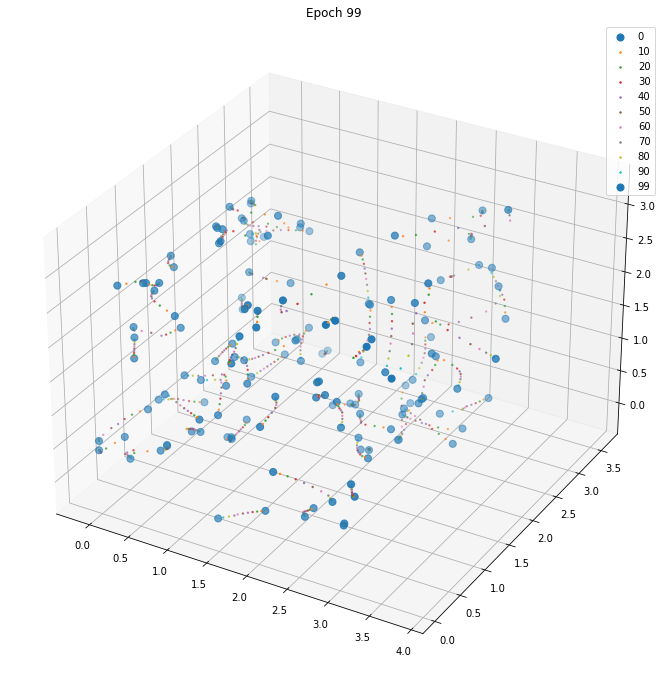

In [8]:
# Deduce the bands
#%matplotlib notebook
epochs = 100
band_gap_energies = torch.zeros((samples))
LR = 1
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

for epoch in range(epochs):
    if epoch==0 or epoch == epochs-1:
        plotting = random_k_positions.clone().detach().numpy()
        ax.scatter(plotting[:, 0], plotting[:, 1], plotting[:, 2], label=epoch, s=50)
        ax.set_title(f"Epoch {epoch}")
    elif epoch%10==0:
        plotting = random_k_positions.clone().detach().numpy()
        ax.scatter(plotting[:, 0], plotting[:, 1], plotting[:, 2], label=epoch, s=2)
        ax.set_title(f"Epoch {epoch}")
    energy_bands = determine_band_structures(interpolated_hoppings, trivial_R, random_k_positions)
    # Squares as the gradient of the dirac point tends to become constant, which can cause issue with equal size steps for
    # gadient descent. So squaring is used for convergence
    average_bandgap = torch.real(torch.mean(torch.abs(energy_bands[:, 12]- energy_bands[:, 11])))
    gradients = torch.autograd.grad(average_bandgap, random_k_positions)[0]
    #print(gradients, LR, average_bandgap)
    random_k_positions -= gradients
    print(epoch, average_bandgap)

    #cost.backward()
    #print(random_k_positions)
plt.legend()
plt.show()

#fig = plt.figure(figsize=(12, 12))
#ax = fig.add_subplot(projection='3d')
#plotting = random_k_positions.clone().detach().numpy()
#ax.scatter(plotting[:, 0], plotting[:, 1], plotting[:, 2])
#ax.set_title(f"Epoch {epoch}")
#plt.show()



In [9]:
#bandgap_energies = torch.abs(energy_bands[:, 12]- energy_bands[:, 11]).detach().numpy()
#print()
#plt.plot(np.arange(len(bandgap_energies)), np.sort(bandgap_energies))
#plt.show()

NameError: name 'K_vectors' is not defined

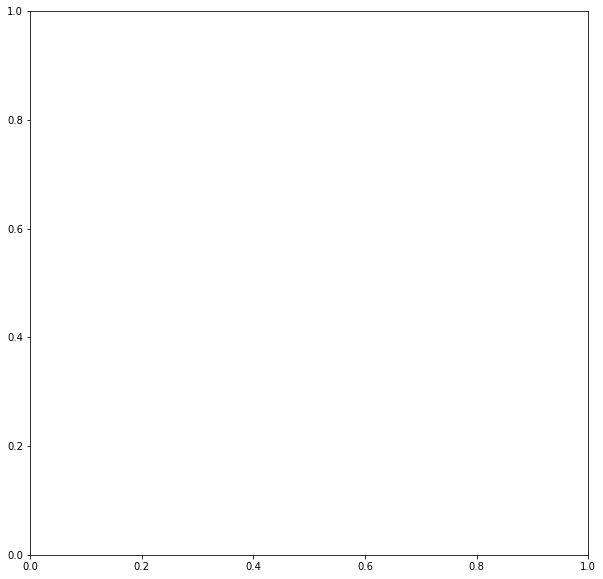

In [10]:
# Plot the graph
fig, ax = plt.subplots(1, figsize=(10, 10))

band11 = [energy_bands[i][11].detach().numpy() for i in range(K_vectors.shape[0])]
band12 = [energy_bands[i][12].detach().numpy() for i in range(K_vectors.shape[0])]
ax.plot(band11)
ax.plot(band12)

        
ax.set_ylim(-1, 10)
ax.set_ylabel("Energy/eV")
ax.set_xlabel("Steps along specified position")
ax.set_title(f"Energy Bands for\n{1-interpolation_parameter:3.2f} x Trivial + {interpolation_parameter:3.2f} x Toplogical")
    
plt.show()

# Band number 12 and 13, 6 P electrons for tellurium and iodide, remaining 6 bands from bismuth
# Z2 index
# Gradient descent
# Begin thesis 20pages (presentation is the main thing)